
# Classify soundtypes with unsupervised learning

Unsupervised learning algorithms search for structures or patterns in a dataset without requiring labels. In the context of ecoacoustics, this approach can be usefull to draw inferences when manual labelling is inaccesible or too expensive. For example, unsupervised learning can be used to estimate the animal acoustic diversity [1], combine human-reasoning and automated procedures to build reference libraries, and find hidden structures in the soundscapes. 

In this example, we will use unsupervised learning to automatically annotate multiple sounds in an audio recording.  The process follows four main steps. We will (i) find sounds that can be delimited in time and frequency, here defined as regions of interest (ROIs), (ii) characterize ROIs by features in the time-frequency domain using 2D wavelets [2], (iii) use t-SNE, a dimensionality reduction algorithm, to reduce the dimensionality of the data [3], and (iv) a automatically form homogenous groups using DBSCAN [4]. We will use a real audio file recorded with an omnidirectional microphone. This audio has a poor signal-to-noise ratio, which is typical of automated audio recordings.

**Dependencies**: This example requires the Python package scikit-learn v0.24 or greater.


In [2]:
# sphinx_gallery_thumbnail_path = './_images/sphx_glr_plot_unsupervised_sound_classification_004.png'

## Load required modules



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from maad import sound, features, rois
from maad.util import power2dB, plot2d, format_features, overlay_rois

Start by loading an example audio file. We will remove low frequency ambient noise with a lowpass filter and then compute the spectrogram.



(<Axes: xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1814.21x579.062 with 2 Axes>)

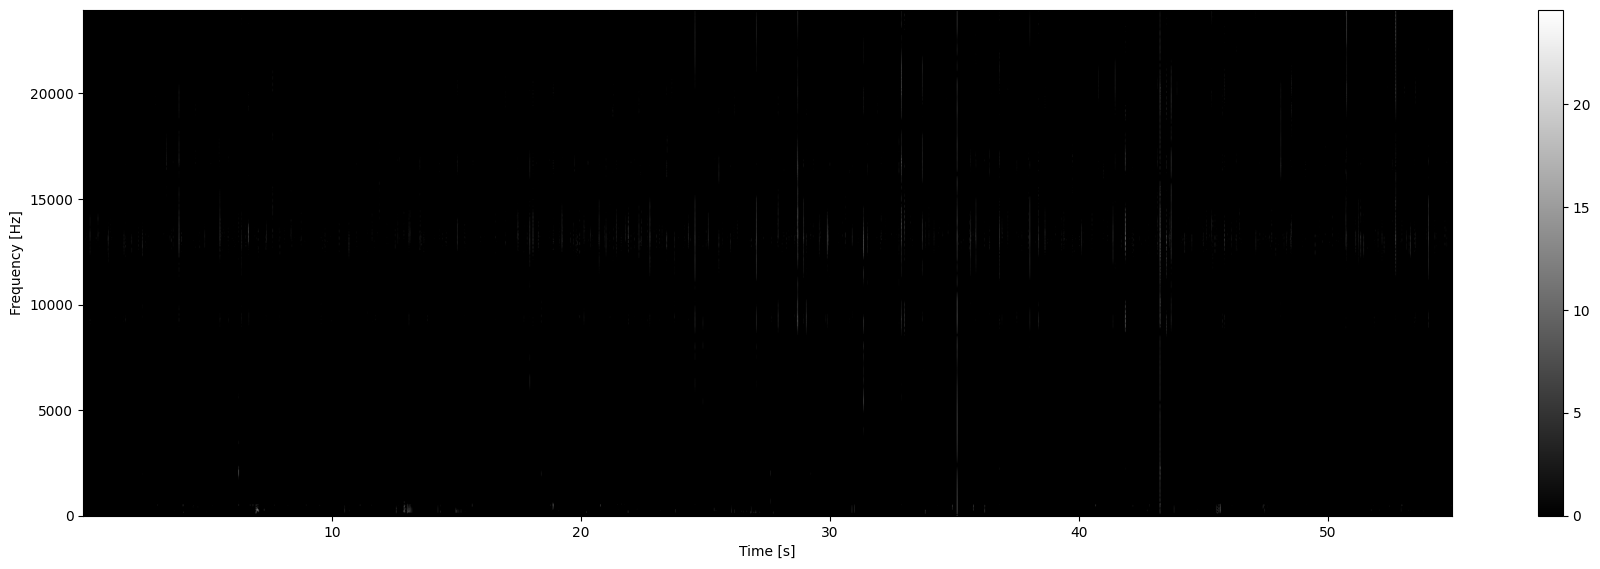

In [7]:
s, fs = sound.load("D:/Aqoustics/Fish/Y_N_Fish/Site 4.2.2/20211014_061700.WAV")
s_filt = sound.select_bandwidth(s, fs, fcut=100, forder=3, ftype='highpass')

db_max=70  # used to define the range of the spectrogram
Sxx, tn, fn, ext = sound.spectrogram(s_filt, fs, nperseg=1024, noverlap=512)
Sxx_db = power2dB(Sxx, db_range=db_max) + db_max
plot2d(Sxx_db, **{'extent':ext})

## 1. Find regions of interest
To find regions of interest in the spectrogram, we will remove stationary background noise and then find isolated sounds using a double threshold method. Small ROIs due to noise in the signal will be removed.



In [123]:
import itertools
import math

# Define the lists of values for each parameter
std_values = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
bin_std_values = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
bin_per_values = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
tags = [5, 14, 45, 19, 10, 22, 24, 26, 31, 34, 35, 36, 44, 7, 27, 47, 13]

# Frequency threshold
freq_threshold = 2000

# Function to check if a sound falls under 2000Hz
def sound_under_2000hz(min_freq, max_freq):
    return max_freq <= freq_threshold

# Function to determine if a timestamp falls within a tag
def within_time_range(start_time, end_time, tags):
    rounded_start_time = math.floor(start_time)
    return any(rounded_start_time <= tag <= end_time for tag in tags)

# Generate all possible combinations of the parameters
combinations = list(itertools.product(std_values, bin_std_values, bin_per_values))

# Track the best combinations
best_combinations = {1: [], 2: [], 3: [], 4: [], 5: []}
perfect_combinations = []
max_correct_count = 0

# Loop through each combination and apply the operations
results = []
for std, bin_std, bin_per in combinations:
    Sxx_db_rmbg, _, _ = sound.remove_background(Sxx_db)
    Sxx_db_smooth = sound.smooth(Sxx_db_rmbg, std=std)
    im_mask = rois.create_mask(im=Sxx_db_smooth, mode_bin='relative', bin_std=bin_std, bin_per=bin_per)
    im_rois, df_rois = rois.select_rois(im_mask, min_roi=50, max_roi=None)
    # Format ROIs and visualize the bounding box on the audio spectrogram.
    df_rois = format_features(df_rois, tn, fn)
    
    correct_count = 0
    false_positive_count = 0
    
    # Iterate through each row in df_rois
    for index, row in df_rois.iterrows():
        min_freq = row['min_f']
        max_freq = row['max_f']
        start_time = row['min_t']
        end_time = row['max_t']
        
        if sound_under_2000hz(min_freq, max_freq):
            if within_time_range(start_time, end_time, tags):
                correct_count += 1
            else:
                false_positive_count += 1
    
    correct_percentage = (correct_count / len(tags)) * 100
    
    # Store the result for later use if needed
    results.append((im_rois, df_rois, correct_count, false_positive_count, correct_percentage))
    
    # Check if the correct percentage is 100% or higher
    if correct_percentage >= 100:
        perfect_combinations.append((std, bin_std, bin_per, correct_count, false_positive_count, correct_percentage))
    else:
        # Check if this combination has 1, 2, 3, 4, or 5 false positives and store it accordingly
        if false_positive_count in best_combinations:
            if correct_count > max_correct_count:
                max_correct_count = correct_count
                best_combinations[false_positive_count] = [(std, bin_std, bin_per, correct_count, correct_percentage)]
            elif correct_count == max_correct_count:
                best_combinations[false_positive_count].append((std, bin_std, bin_per, correct_count, correct_percentage))
    
    print(f"Combination (std={std}, bin_std={bin_std}, bin_per={bin_per}):")  
    print(f" - Correctly identified tags: {correct_count} / {len(tags)} ({correct_percentage:.2f}%)")
    print(f" - False Positives: {false_positive_count}")

Combination (std=0.1, bin_std=0.1, bin_per=0.1):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=0.25):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=0.5):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=0.75):
 - Correctly identified tags: 2 / 17 (11.76%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=1):
 - Correctly identified tags: 2 / 17 (11.76%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=1.25):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=1.5):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=1.75):
 - Correctly identified tags: 0 / 17 (0.00%)
 - False Positives: 0
Combination (std=0.1, bin_std=0.1, bin_per=2):
 - Correctly identifi

KeyboardInterrupt: 

In [ ]:
# Print the combinations with 100% or higher correct percentage
if perfect_combinations:
    print("\nCombinations with 100% or higher Correct Percentage:")
    for combo in perfect_combinations:
        print(f" - std={combo[0]}, bin_std={combo[1]}, bin_per={combo[2]}: Correctly identified tags = {combo[3]}, False Positives = {combo[4]}, Correct Percentage = {combo[5]:.2f}%")

In [122]:
# Print the best combinations for 1-5 false positives
for fp_count in range(0, 7):
    if best_combinations[fp_count]:
        print(f"\nBest combinations with {fp_count} false positives:")
        for combo in best_combinations[fp_count]:
            print(f" - std={combo[0]}, bin_std={combo[1]}, bin_per={combo[2]}: Correctly identified tags = {combo[3]}, Correct Percentage = {combo[4]:.2f}%")


Best combinations with 0 false positives:
 - std=0.1, bin_std=0.1, bin_per=0.75: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.1, bin_std=0.1, bin_per=1: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.1, bin_std=0.25, bin_per=0.75: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.1, bin_std=0.25, bin_per=1: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.25, bin_std=0.1, bin_per=0.1: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.25, bin_std=0.1, bin_per=0.25: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.25, bin_std=0.1, bin_per=0.5: Correctly identified tags = 2, Correct Percentage = 11.76%
 - std=0.25, bin_std=0.1, bin_per=0.75: Correctly identified tags = 2, Correct Percentage = 11.76%

Best combinations with 1 false positives:
 - std=0.25, bin_std=0.1, bin_per=1: Correctly identified tags = 7, Correct Percentage = 41.18%
 - std=0.25, bin_std=0.25, bin_per=1

In [107]:
import pandas as pd

def filter_rois_above_2000Hz(df):
    """
    Filters out ROIs where the maximum frequency (max_y) exceeds 2000Hz.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the ROIs with 'min_y', 'min_x', 'max_y', 'max_x'.

    Returns:
    pd.DataFrame: A filtered DataFrame with ROIs below or equal to 2000Hz.
    """
    # Filter the DataFrame to remove rows where max_y exceeds 2000
    filtered_df = df[df['max_f'] <= 2000].reset_index(drop=True)
    return filtered_df




In [108]:
Sxx_db_rmbg, _, _ = sound.remove_background(Sxx_db)
Sxx_db_smooth = sound.smooth(Sxx_db_rmbg, std=1.5)
im_mask = rois.create_mask(im=Sxx_db_smooth, mode_bin ='relative', bin_std=1.5, bin_per=0.1)
im_rois, df_rois = rois.select_rois(im_mask, min_roi=50, max_roi=None)


# Format ROIs and visualize the bounding box on the audio spectrogram.
df_rois = format_features(df_rois, tn, fn)
df_rois = filter_rois_above_2000Hz(df_rois)


In [109]:
df_rois

,labelID,label,min_y,min_x,max_y,max_x,min_f,min_t,max_f,max_t
0,1,unknown,0,648,13,664,0.000,6.922667,609.375,7.093333
1,2,unknown,0,1204,16,1241,0.000,12.853333,750.000,13.248000
2,3,unknown,0,2511,10,2518,0.000,26.794667,468.750,26.869333
3,7,unknown,0,4264,14,4286,0.000,45.493333,656.250,45.728000
4,9,unknown,1,982,11,988,46.875,10.485333,515.625,10.549333
5,10,unknown,1,1176,11,1182,46.875,12.554667,515.625,12.618667
6,12,unknown,1,1400,9,1417,46.875,14.944000,421.875,15.125333
7,16,unknown,1,2438,10,2444,46.875,26.016000,468.750,26.080000
8,18,unknown,1,2522,6,2537,46.875,26.912000,281.250,27.072000
9,20,unknown,1,2892,12,2898,46.875,30.858667,562.500,30.922667


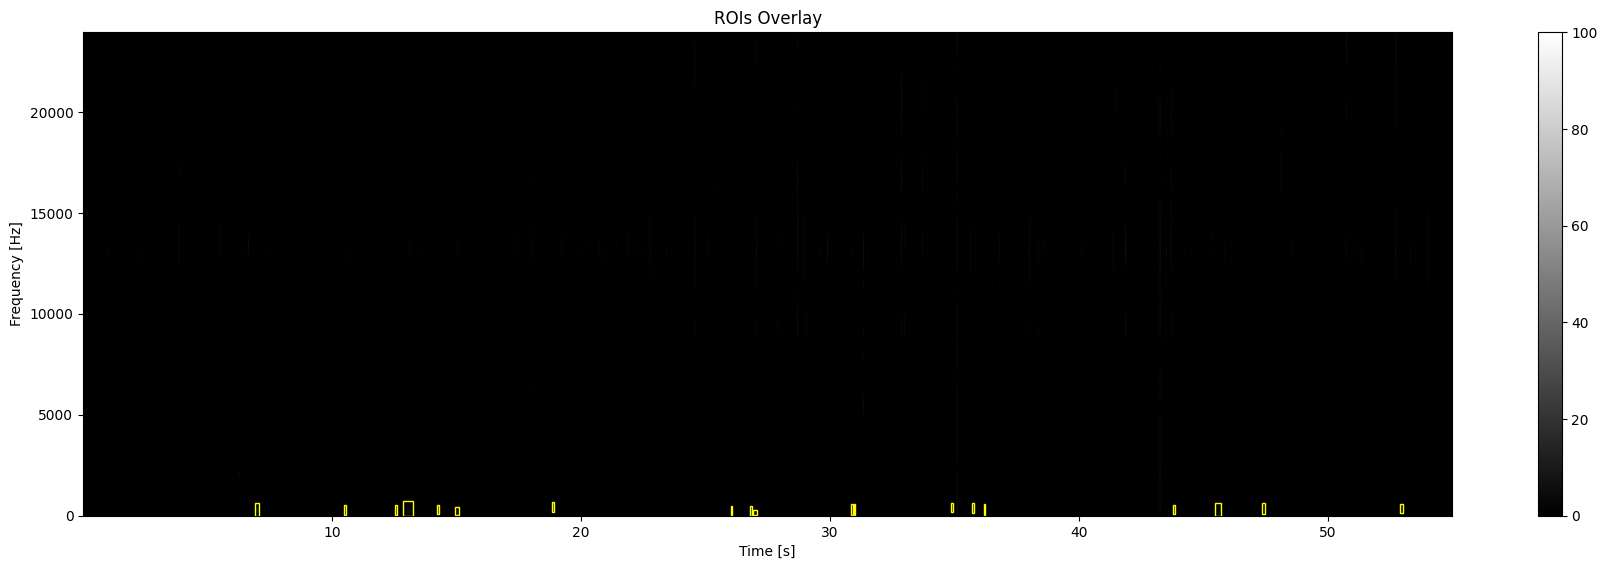

In [110]:
ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':100, 'extent':ext})


## 2. Compute acoustic features
The ``shape_feaures`` function uses bidimensional wavelets to get the texture and spectro-temporal shape coeficients of each ROI. Wavelets have the advantage of being robust when the signal-to-noise ratio is low, and derive homogeneous descriptors which facilitate the clustering process. The wavelet decomposition is performed on the complete spectrogram, hence the coeficients for ROIs do not vary much even when not the time-frequency bounds are not exact. The centroid features gives an estimate of the median frequency of the ROIs.



In [111]:
df_shape, params = features.shape_features(Sxx_db, resolution='low', rois=df_rois)
df_centroid = features.centroid_features(Sxx_db, df_rois)

# Get median frequency and normalize
median_freq = fn[np.round(df_centroid.centroid_y).astype(int)]
df_centroid['centroid_freq'] = median_freq/fn[-1]

## 3. Reduce the dimensionality of the features
The shape audio features have 26 dimensions. To facilitate the clustering process and visualize the results, it is posible to use non-metric dimensionality reduction algorithm, namely the t-distributed stochastic neighbor embedding (t-SNE), to proyect the data in two dimensions.



[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 1.259281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.645035
[t-SNE] KL divergence after 1000 iterations: 0.132216


Text(0, 0.5, 'tsne dim 2')

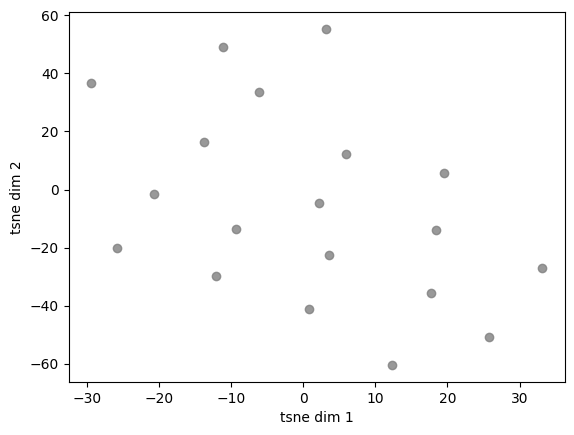

In [112]:
from sklearn.manifold import TSNE

X = df_shape.loc[:,df_shape.columns.str.startswith('shp')]
X = X.join(df_centroid.centroid_freq) # add column and normalize values

tsne = TSNE(n_components=2, perplexity=12, init='pca', verbose=True)
Y = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c='gray', alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

## 4. Cluster the ROIs into homogeneous groups. 
In the above plot it is possible to observe how sounds are aggregated. It is posible to group these samples rapidly and objectively using a clustering algorithm. Here, we will use DBSCAN, a simple algorithm that allows to find core samples with high density and expands clusters from them. This algorithm has the advantage to find automatically the number of clusters and can cope with unbalanced classes.



In [116]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(eps=1, min_samples=3).fit(Y)
print('Number of soundtypes found:', np.unique(cluster.labels_).size)

Number of soundtypes found: 1


Visualize the clustering results



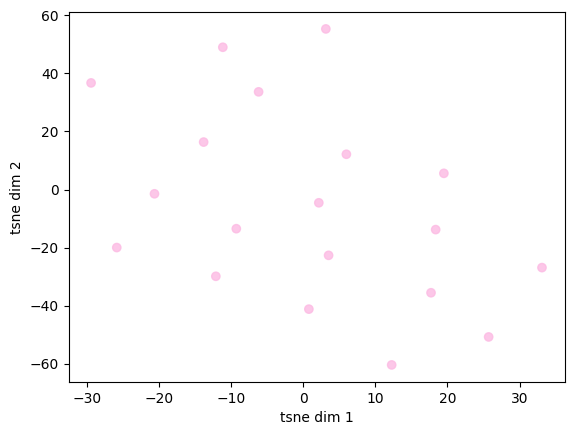

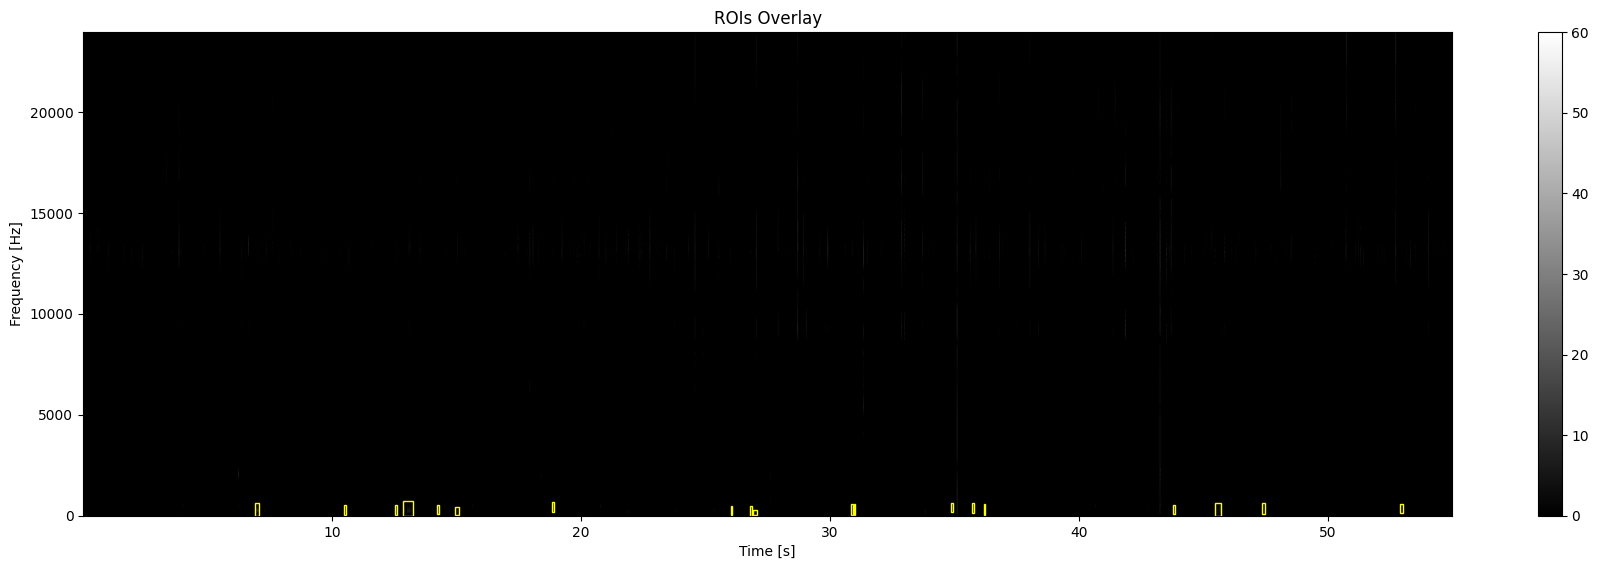

In [117]:
from maad.util import rand_cmap
fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c=cluster.labels_, cmap=rand_cmap(5 , first_color_black=False), alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

# Overlay bounding box on the original spectrogram
df_rois['label'] = cluster.labels_.astype(str)
ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':60, 'extent':ext})

## References
1. Ulloa, J. S., Aubin, T., Llusia, D., Bouveyron, C., & Sueur, J. (2018). Estimating animal acoustic diversity in tropical environments using unsupervised multiresolution analysis. Ecological Indicators, 90, 346–355. https://doi.org/10.1016/j.ecolind.2018.03.026
2. Sifre, L., & Mallat, S. (2013). Rotation, scaling and deformation invariant scattering for texture discrimination. Computer Vision and Pattern Recognition (CVPR), 2013 IEEE Conference On, 1233–1240. http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=6619007
3. Maaten, L. van der, & Hinton, G. (2008). Visualizing data using t-SNE. Journal of Machine Learning Research, 9(Nov), 2579–2605.
4. Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, 96(34), 226–231.
